<a href="https://colab.research.google.com/github/LanesG/colab/blob/master/CNN_Dog_Races_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importieren der Libraries

In [2]:
!pip install --upgrade deeplearning2020

     |████████████████████████████████| 399kB 9.9MB/s 
  Created wheel for deeplearning2020: filename=deeplearning2020-0.4.21-py2.py3-none-any.whl size=8548 sha256=1eebb08ff392def19982280d42ecbd4230e48b649bd1b66d0d76eb43e0ef919a
  Stored in directory: /root/.cache/pip/wheels/7f/c2/8a/f9f03fc839999f1fe9d5e5a9d2c97cdd5cb8329f61f82ea2c9
  Created wheel for kerasltisubmission: filename=kerasltisubmission-0.4.9-py2.py3-none-any.whl size=8867 sha256=3a6704627bf52c64073ed633fa03692f5c3fd98f1e968d4aa1ccd031306d4fc8
  Stored in directory: /root/.cache/pip/wheels/fd/61/f7/09171376b25408ae21b58e98c9fbf2eb924f676bb77659f983
Successfully built deeplearning2020 kerasltisubmission


In [0]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input, Dropout, BatchNormalization, GaussianNoise, \
  Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

from deeplearning2020 import helpers

In [0]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.\nGo to Runtime > Change runtime and select a GPU hardware accelerator.")

# Die Daten

## Laden der Daten

In [23]:
from deeplearning2020.datasets import ImageWoof

train_data, test_data, classes = ImageWoof.load_data()

/root/.keras/datasets/imagewoof2-320/train
Loaded 9025 images
/root/.keras/datasets/imagewoof2-320/val
Loaded 3929 images


## Informationen über die Datensätze anzeigen
Die Bildpunkte sind als Floats zwischen 0 und 1 gespeichert.  
Die Labels der Daten liegen in sparse Form vor.

In [18]:
print("Trainingsdaten")
print(train_data)

print("Testdaten")
print(test_data)

print("Klassen")
print(classes)

Trainingsdaten
<ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
Testdaten
<ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
Klassen
['Shih-Tzu' 'Rhodesian ridgeback' 'Beagle' 'English foxhound'
 'Border terrier' 'Australian terrier' 'Golden retriever'
 'Old English sheepdog' 'Samoyed' 'Dingo']


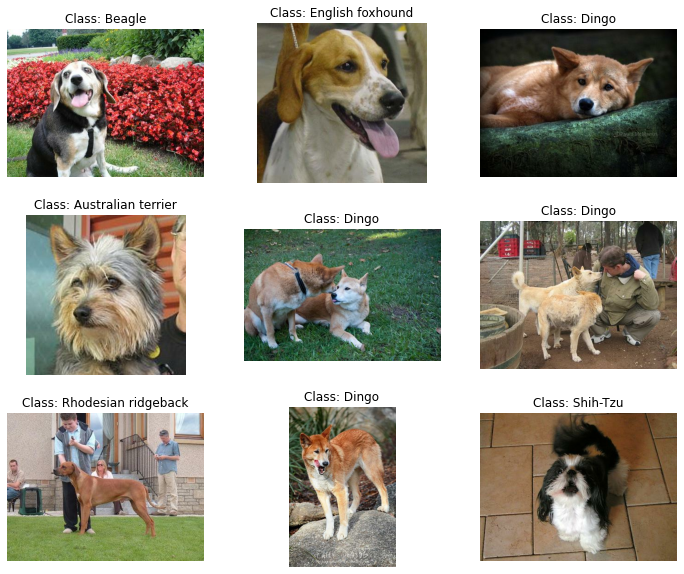

In [24]:
helpers.plot_images(train_data.take(9), classes)

## Preprocessing der Daten

In [0]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [300, 300])
    # run Xceptions preprocessing function
    #preprocessed_image = tf.keras.applications.xception.preprocess_input(resized_image)
    #return preprocessed_image, label
    return resized_image, label

In [31]:
# Festlegung der Batch Größe für die Datenvorbereitung
batch_size = 32 

# Durchmischen der Trainingsdaten, dass nicht mit sortierten Bildern trainiert wird 
train_data = train_data.shuffle(1000) 

print('shape des Trainigsdatensatzes vor dem preprocessing: ', train_data)

train_data = train_data.map(preprocess).batch(batch_size).prefetch(1)          
test_data = test_data.map(preprocess).batch(batch_size).prefetch(1)

print('shape des Traingingsdatensatzes nach dem preprocessing: ', train_data)

shape des Trainigsdatensatzes vor dem preprocessing:  <ShuffleDataset shapes: ((300, 300, 3), ()), types: (tf.float32, tf.int64)>
shape des Traingingsdatensatzes nach dem preprocessing:  <PrefetchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)>


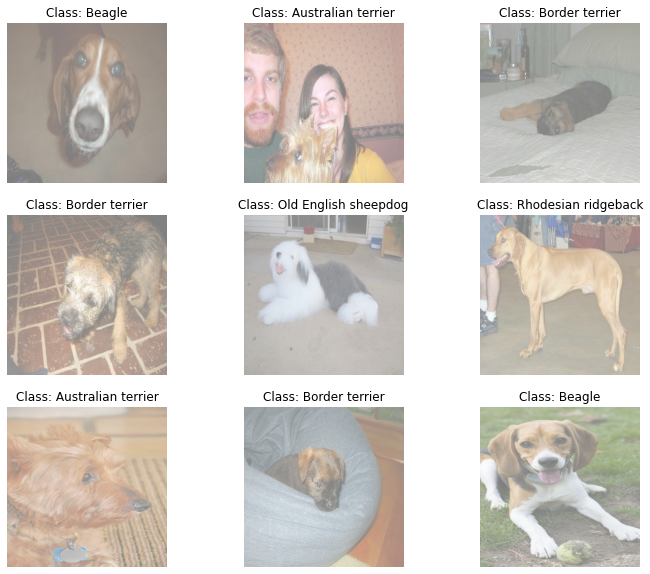

In [36]:
helpers.plot_images(train_data.unbatch().take(9).map(lambda x, y: ((x + 1) / 2, y)), classes)

# Das Netz

In [0]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D

# build a transfer learning model with Xception and a new Fully-Connected-Classifier
base_model = Xception(
    weights='imagenet',
    include_top=False
)
model = GlobalAveragePooling2D()(base_model.output)
model = Dropout(0.5)(model)

# include new Fully-Connected-Classifier
output_layer = Dense(10, activation='softmax')(model)

# create Model
model = Model(base_model.input, output_layer)

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [0]:
# set the pretrained layers to not trainable because
# there are already trained and we don't want to destroy
# their weights
for layer in base_model.layers:
  layer.trainable = False

## Kompilieren des Netzes

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Trainieren des Netzes

In [40]:
history = model.fit(
    train_data,
    epochs=5,
    validation_data=test_data
)

Epoch 1/5
283/283 [==============================] - 54s 192ms/step - loss: 0.1743 - accuracy: 0.9543 - val_loss: 0.1261 - val_accuracy: 0.9669
Epoch 2/5
283/283 [==============================] - 53s 188ms/step - loss: 0.0876 - accuracy: 0.9730 - val_loss: 0.1210 - val_accuracy: 0.9656
Epoch 3/5
283/283 [==============================] - 53s 188ms/step - loss: 0.0731 - accuracy: 0.9767 - val_loss: 0.1159 - val_accuracy: 0.9659
Epoch 4/5
283/283 [==============================] - 53s 188ms/step - loss: 0.0700 - accuracy: 0.9781 - val_loss: 0.1160 - val_accuracy: 0.9672
Epoch 5/5
283/283 [==============================] - 53s 188ms/step - loss: 0.0632 - accuracy: 0.9797 - val_loss: 0.1139 - val_accuracy: 0.9667


## Evaluieren des Netzes

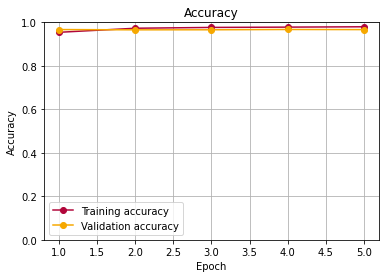

In [41]:
helpers.plot_history('Accuracy', history, 0)

## Feintuning

In [0]:
# to finetune the model, we have to set more layers to trainable
# and reduce the learning rate drastically to prevent
# destroying of weights
for layer in base_model.layers:
  layer.trainable = True

In [0]:
# reduce the learning rate to not damage the pretrained weights
# model will need longer to train because all the layers are trainable
model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
history_finetune=model.fit(
    train_data,
    epochs=10,
    validation_data=test_data
)

Epoch 1/10
283/283 [==============================] - 208s 735ms/step - loss: 0.1798 - accuracy: 0.9434 - val_loss: 0.1919 - val_accuracy: 0.9458
Epoch 2/10
283/283 [==============================] - 208s 735ms/step - loss: 0.0810 - accuracy: 0.9756 - val_loss: 0.1903 - val_accuracy: 0.9488
Epoch 3/10
283/283 [==============================] - 208s 736ms/step - loss: 0.0313 - accuracy: 0.9909 - val_loss: 0.1779 - val_accuracy: 0.9468
Epoch 4/10
283/283 [==============================] - 208s 734ms/step - loss: 0.0189 - accuracy: 0.9953 - val_loss: 0.1750 - val_accuracy: 0.9578
Epoch 5/10
 25/283 [=>............................] - ETA: 2:49 - loss: 0.0173 - accuracy: 0.9962

KeyboardInterrupt: ignored

In [45]:
helpers.plot_two_histories(history, history_finetune)

NameError: ignored